In [1]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import tellurium as te
from odbm.odbm import ModelBuilder, ModelHandler
import matplotlib.pyplot as plt
from odbm.vis import *
from odbm.utils import extractParams, fmt, getStoich
import itertools


C:\Users\dex36\miniconda2\envs\ODBM\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\dex36\miniconda2\envs\ODBM\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\dex36\miniconda2\envs\ODBM\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
model_species = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Species & Base Mechanisms', engine = 'openpyxl').dropna('index','all')
model_rxns = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Reaction', engine = 'openpyxl').dropna('index','all')

In [4]:
expression_limit = 0.05 
enzyme_ratio = {'Sda':1, 'PCX': 1, 'Mdh': 1}
N_ratios = sum(enzyme_ratio.values())
expression_fudge = 1/10
enzymeInit = {k:expression_limit*expression_fudge/N_ratios*v for k,v in enzyme_ratio.items()}

solubilities = {    'ATP' : 98.619,
                    'Serine': 2380.952,
                    'HCO3' : 1470.588,
                    'NADH' : 150.739 
                }
sol_fudge = 1/20
solubilities = {k:v*sol_fudge for k,v in solubilities.items()}
solubilities['Serine'] = min(solubilities.values())

for k,v in solubilities.items():
    model_species.loc[model_species['Label'] == k,'StartingConc'] = v

# constant_species = ['ATP','NADH']
# # this kind of works
# for s in constant_species:
#     model_species.loc[model_species['Label'] == s,'Label'] = '$'+s

serine_mw = 105.09
malate_mw = 134.0874

In [ ]:
avg_res = 300 # average number of residues
pi_prod = 5 # Pi produced per residue
pi_fudge = 2
max_Pi = expression_limit*avg_res*pi_prod*pi_fudge # max mM of Pi 

In [5]:
N = 100*64
init_serine = {'SERINE':10**np.random.uniform(np.log10(solubilities['Serine']/5), np.log10(solubilities['Serine']*2), N)}
#plt.hist(serine.values())

In [6]:
sdaV = list(map(lambda x:x.upper(),model_species[['Sda' in s for s in model_species['Label']]]['Label']))[:4]
pcxV = list(map(lambda x:x.upper(),model_species[['PCX' in s for s in model_species['Label']]]['Label']))[:4]
mdhV = list(map(lambda x:x.upper(),model_species[['Mdh' in s for s in model_species['Label']]]['Label']))[:4]

picks = np.random.randint(4, size = (3,N))
filter = np.zeros((4,3,N))

for i in range(3):
    filter[picks[i,:],i,np.arange(N)] = 1

init_DNA = dict(zip(['DNA_'+d for d in sdaV+pcxV+mdhV], (10**np.random.uniform(np.log10(1/10000), np.log10(1/100),size = filter.shape)*filter).reshape((12,N),order = 'F')))



In [177]:
tau = 4*60*60
taus = {'tau_'+enz:10**np.random.uniform(np.log10(tau/4),np.log10(tau*2.5), N) for enz in [*sdaV,*pcxV,*mdhV]}

In [7]:
fluxes = {'Pyruvate': 12.478089, 'Serine': 1.678, 'Malate': 6.267} #units of mmol/gDW*hr
amounts = {'Pyruvate': 0.39, 'Serine': 0.068, 'Malate': 1.7} #units of mmol/gDW*hr

prot_dilution_factor = 25*100

def convertFlux(fluxes):
    new_fluxes = {}
    for f in fluxes:
        new_fluxes[f] = (fluxes[f]*(3E-13)/(1E-15))/prot_dilution_factor/3600/amounts[f]
    return new_fluxes

new_fluxes = convertFlux(fluxes)

keys = {'Pyruvate': 'k_R14', 'Serine': 'k_R13', 'Malate': 'k_R15'}
siphon = {k:v for k,v in zip([keys[ky] for ky in new_fluxes.keys()], [10**np.random.uniform(np.log10(s/31), np.log10(s*31), N) for s in new_fluxes.values()])}

In [8]:
params = {**siphon,**init_serine, **init_DNA}

In [180]:
modelfile = 'Examples/multi_enzyme_model.txt'
myModel = ModelBuilder(model_species, model_rxns)
myModel.saveModel(modelfile)

with open(modelfile,'r') as m:
    r  = te.loada(m.read())

In [181]:
results_id = np.empty((len(sdaV), len(pcxV), len(mdhV)), dtype=int)
results = []
selections = list(map(fmt, myModel.species['Label'])) + list(myModel.rxns['Label']) + ['time']

count = 0
for i,sda in enumerate(sdaV):
    for j,pcx in enumerate(pcxV):
        for k,mdh in enumerate(mdhV):
            r.resetAll()
            r['SERINE'] = 3
            r['k_R13'] = new_fluxes['Serine']
            r['k_R14'] = 0
            r['k_R15'] = 0
            r['k_TXTL'] = expression_limit/8/20*10e6/3600


            r['DNA_'+sda] = 1/10e6
            r['DNA_'+pcx] = 1/10e6
            r['DNA_'+mdh] = 1/10e6
            results_id[i,j,k] = count
            results.append(r.simulate(0,24*60*60,1000, selections=selections))
            count += 1

(array([16.,  0., 32.,  0.,  0.,  0.,  0.,  0.,  0., 16.]),
 array([0.21589608, 0.27062646, 0.32535684, 0.38008722, 0.4348176 ,
        0.48954798, 0.54427836, 0.59900874, 0.65373911, 0.70846949,
        0.76319987]),
 <a list of 10 Patch objects>)

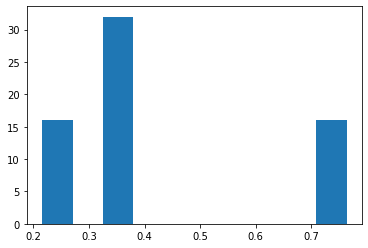

In [182]:
plt.hist([sum([r[v][-1] for v in [*sdaV,*pcxV,*mdhV]])/0.05*100 for r in results])

(array([16.,  0.,  0.,  0.,  0.,  0.,  0., 32.,  0., 16.]),
 array([ 760.48295133,  797.44649135,  834.41003137,  871.37357138,
         908.3371114 ,  945.30065142,  982.26419143, 1019.22773145,
        1056.19127147, 1093.15481148, 1130.1183515 ]),
 <a list of 10 Patch objects>)

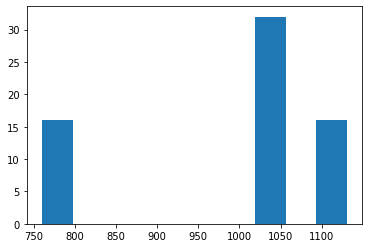

In [183]:
plt.hist([max(r['MALICACID'])*malate_mw/(r['SERINE'][0]*serine_mw)*1000 for r in results])

3.5982704371897786e-05

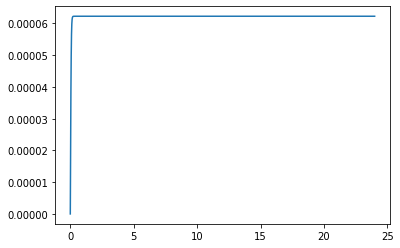

In [184]:
plt.plot(results[0]['time']/60/60,results[32][sdaV[2]])
results[0][pcxV[0]][-1]

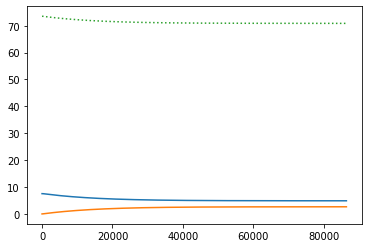

In [185]:
df = pd.DataFrame(results[0], columns = results[0].colnames)
df.round(2)
plt.plot(df['time'],df['NADH'],  label = 'NADH')
plt.plot(df['time'],df['ADP'], label = 'ADP')
plt.plot(df['time'],df['HCO3'],  linestyle = 'dotted', label = 'CO2')

#plt.xlim(0, 100)
#plt.ylim(0,200)


[(0, 300), (0, 300), (0, 300)]

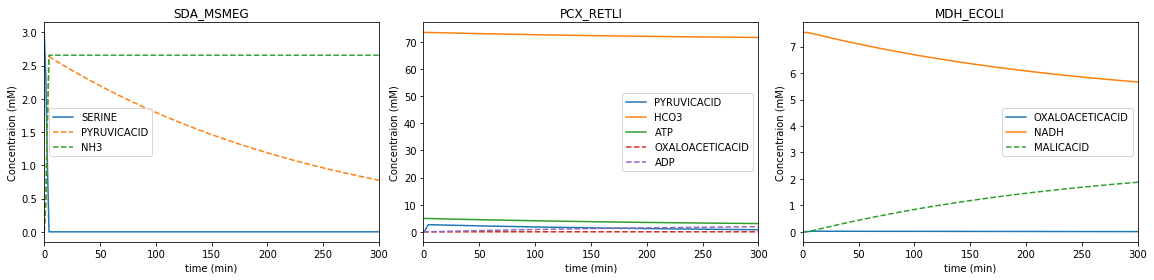

In [186]:
variants = (0,0,0) #define combination of variants to plot
v_labels = [v[k] for v,k in zip([sdaV, pcxV, mdhV], variants)] #get variant names
run = int(results_id[variants]) #return simulation run  # in which that combination was tested
rxn_idx = [int(variants[0]),int(variants[1]+4), int(variants[2]+8)] #brute force method of getting reaction index for each variant
f, ax = rxn_plot(myModel, results[run], rxn_idx, figsize=(16,4), titles = v_labels)
[a.set_xlim([0,300]) for a in ax]

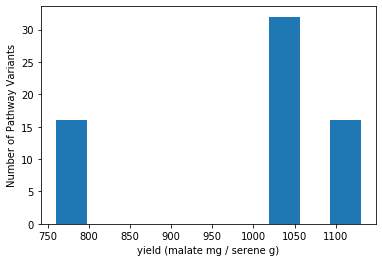

In [187]:
plt.hist([((max(r['MALICACID'])*malate_mw)/(r['SERINE'][0]*serine_mw)*1000) for r in results]);
plt.xlabel('yield (malate mg / serene g)');
plt.ylabel('Number of Pathway Variants');

(0, 200)

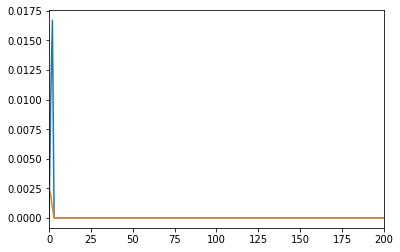

In [188]:
plt.plot(results[0]['R1'])
plt.plot(results[0]['R13'])

plt.xlim([0,200])


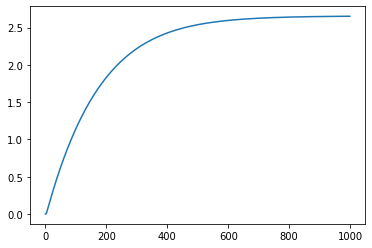

In [189]:
plt.plot(results[0]['MALICACID'])

In [9]:
modelfile = 'Examples/multi_enzyme_model.txt'
myModel = ModelBuilder(model_species, model_rxns)
myModel.saveModel(modelfile)

with open(modelfile,'r') as m:
    MH = ModelHandler(m.read())

selections = list(map(fmt, myModel.species['Label'])) + list(myModel.rxns['Label']) + ['time']
MH.setSimParams(0,24*60*60,200, selections=selections)

MH.setParameterScan(params)
yld = lambda x: ((max(x['MALICACID'])*malate_mw)/(x['SERINE'][0]*serine_mw)*1000)
amt = lambda x: (max(x['MALICACID'])*malate_mw)*1000

etot = []
for es in [sdaV,pcxV,mdhV]:
    etot.append(lambda x: sum([max(x['DNA_'+e]) for e in es]))


In [10]:
results, metrics = MH.sensitivityAnalysis(metrics = [yld,amt,*etot])
parray = MH.conditions

Text(0.5, 0, 'Yield (mg malate/g serine)')

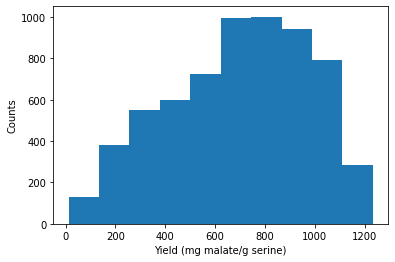

In [13]:
# import seaborn
ylds = metrics[:,0]
plt.hist(ylds)
plt.ylabel('Counts')
plt.xlabel('Yield (mg malate/g serine)')
#seaborn.distplot(ylds, kde = False)

<AxesSubplot:>

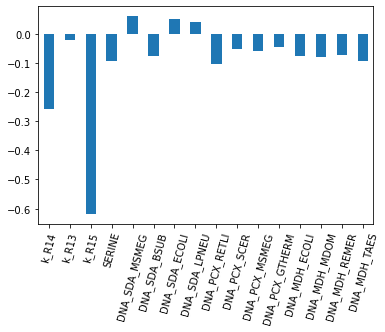

In [14]:
df = pd.DataFrame({**params,'yld':ylds})
(df.corr()['yld'][params.keys()]).plot(kind = 'bar', legend = False, rot = 75)

In [15]:
var_names = (['DNA_'+d for d in sdaV+pcxV+mdhV])
corr_list = []
for idx,v in enumerate(var_names):
    temp_df = df.loc[df[v] != 0]
    corr_list.append(temp_df.corr()['yld'][params.keys()][idx+4])


<BarContainer object of 12 artists>

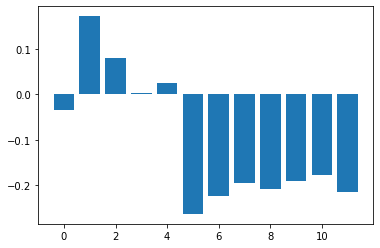

In [19]:
plt.bar(np.arange(12),corr_list)

(array([657., 718., 608., 619., 671., 628., 606., 610., 664., 619.]),
 array([-3.52231957, -3.32238525, -3.12245092, -2.9225166 , -2.72258228,
        -2.52264796, -2.32271363, -2.12277931, -1.92284499, -1.72291067,
        -1.52297634]),
 <BarContainer object of 10 artists>)

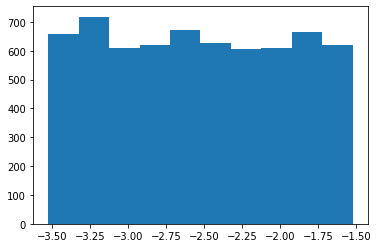

In [16]:
plt.hist(np.log10(np.sum(metrics[:,2:],axis=1)))

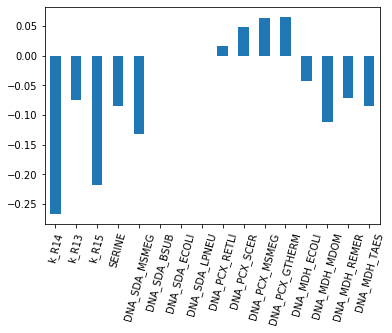

In [77]:
df = pd.DataFrame(parray, columns=params.keys())
df['yld'] = ylds

(df[df['DNA_'+sdaV[0]]>0].corr()['yld'][params.keys()]).plot(kind = 'bar', legend = False, rot = 75)

C:\Users\Diego Alba\.conda\envs\ODBM\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

divide by zero encountered in log10



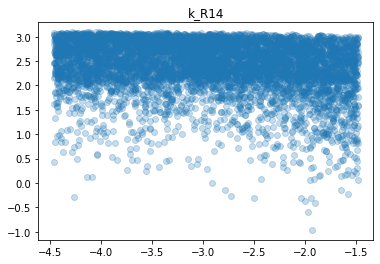

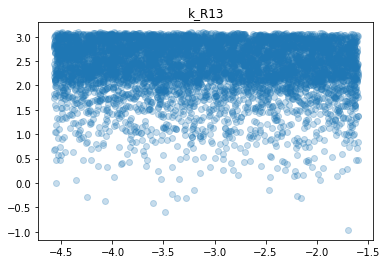

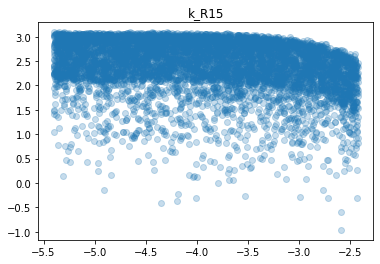

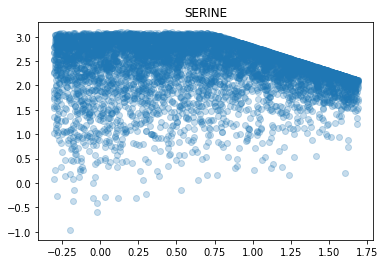

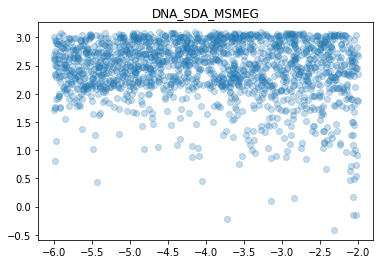

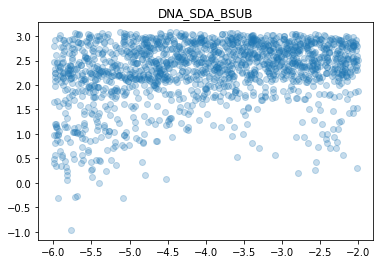

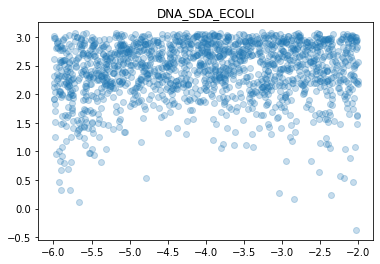

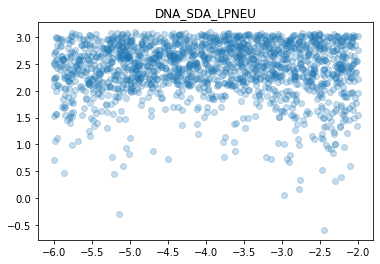

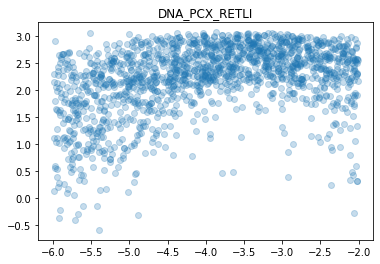

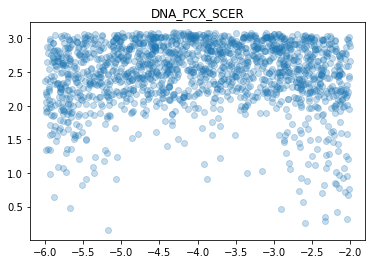

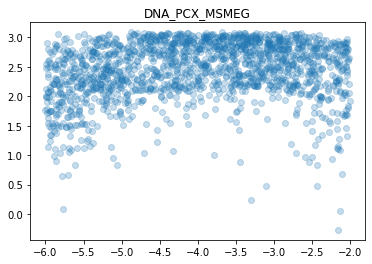

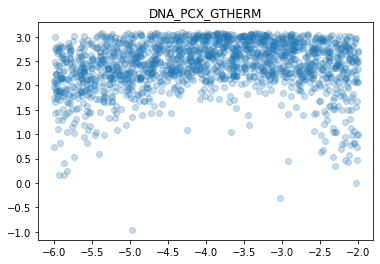

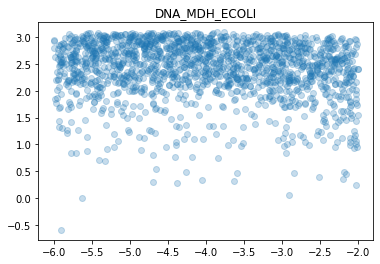

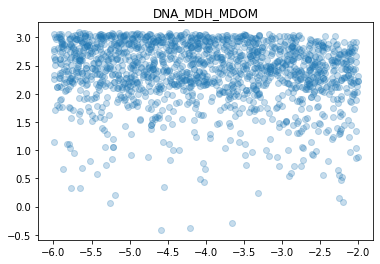

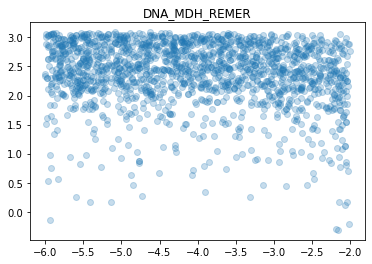

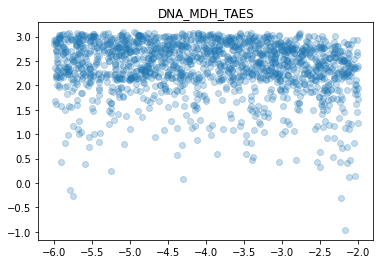

In [277]:
df = pd.DataFrame(params)
for k,v in params.items():
    plt.figure()
    plt.scatter(np.log10(v),np.log10(metrics[:,0]), alpha = 0.25)
    plt.title(k) 

In [56]:
from odbm.events import *
with open(modelfile,'r') as m:
    r  = te.loada(m.read())


In [58]:
labels = 'test1, test2'
events = 'ATP = 1, SERINE = 1'
addEvents(r, labels, events, 'time > 0')
#removeEvents(r, labels)
forceRegenerate(r)

In [262]:
import plotly.express as px
total = (MH.conditions[:,4:].sum(1))
stats = (MH.conditions[:,4:8].sum(1))/total
bus = (MH.conditions[:,8:12].sum(1))/total
design = (MH.conditions[:,12:].sum(1))/total
df = pd.DataFrame({'Sda':stats, 'PCX':bus, 'Mdh':design, "Yield": ylds})
fig = px.scatter_ternary(df, a="Sda", b="PCX", c="Mdh", opacity =0.05, color = "Yield", size = np.ones(N), size_max=25)
fig.show()